### Notes:

- Hyperparameter tuning is attempted for better results but could not be completed due to limited resourses.

In [1]:
# !pip install shap

In [2]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Models
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Explainability
import shap

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the datasets
train_df = pd.read_csv("fraudTrain.csv", index_col=0)
test_df = pd.read_csv("fraudTest.csv", index_col=0)

print(len(train_df))
print(len(test_df))

# train_df = train_df[:int(0.01*len(train_df))]
# test_df = test_df[:int(0.01*len(test_df))]

# train_df.to_csv("fraudTrain_0p001.csv")
# test_df.to_csv("fraudTest_0p001.csv")

1296675
555719


In [4]:
train_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [5]:
test_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [34]:
train_df.shape

(1296675, 22)

In [35]:
test_df.shape

(555719, 22)

In [36]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop               

In [37]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 555719 entries, 0 to 555718
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  555719 non-null  object 
 1   cc_num                 555719 non-null  int64  
 2   merchant               555719 non-null  object 
 3   category               555719 non-null  object 
 4   amt                    555719 non-null  float64
 5   first                  555719 non-null  object 
 6   last                   555719 non-null  object 
 7   gender                 555719 non-null  object 
 8   street                 555719 non-null  object 
 9   city                   555719 non-null  object 
 10  state                  555719 non-null  object 
 11  zip                    555719 non-null  int64  
 12  lat                    555719 non-null  float64
 13  long                   555719 non-null  float64
 14  city_pop               555719 non-null  i

In [38]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
cc_num,1296675.0,4.171920e+17,1.308806e+18,6.041621e+10,1.800429e+14,3.521417e+15,4.642255e+15,4.992346e+18
amt,1296675.0,7.035104e+01,1.603160e+02,1.000000e+00,9.650000e+00,4.752000e+01,8.314000e+01,2.894890e+04
zip,1296675.0,4.880067e+04,2.689322e+04,1.257000e+03,2.623700e+04,4.817400e+04,7.204200e+04,9.978300e+04
lat,1296675.0,3.853762e+01,5.075808e+00,2.002710e+01,3.462050e+01,3.935430e+01,4.194040e+01,6.669330e+01
long,1296675.0,-9.022634e+01,1.375908e+01,-1.656723e+02,-9.679800e+01,-8.747690e+01,-8.015800e+01,-6.795030e+01
city_pop,1296675.0,8.882444e+04,3.019564e+05,2.300000e+01,7.430000e+02,2.456000e+03,2.032800e+04,2.906700e+06
unix_time,1296675.0,1.349244e+09,1.284128e+07,1.325376e+09,1.338751e+09,1.349250e+09,1.359385e+09,1.371817e+09
merch_lat,1296675.0,3.853734e+01,5.109788e+00,1.902779e+01,3.473357e+01,3.936568e+01,4.195716e+01,6.751027e+01
merch_long,1296675.0,-9.022646e+01,1.377109e+01,-1.666712e+02,-9.689728e+01,-8.743839e+01,-8.023680e+01,-6.695090e+01
is_fraud,1296675.0,5.788652e-03,7.586269e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [39]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
cc_num,555719.0,4.178387e+17,1.309837e+18,6.041621e+10,1.800429e+14,3.521417e+15,4.635331e+15,4.992346e+18
amt,555719.0,6.939281e+01,1.567459e+02,1.000000e+00,9.630000e+00,4.729000e+01,8.301000e+01,2.276811e+04
zip,555719.0,4.884263e+04,2.685528e+04,1.257000e+03,2.629200e+04,4.817400e+04,7.201100e+04,9.992100e+04
lat,555719.0,3.854325e+01,5.061336e+00,2.002710e+01,3.466890e+01,3.937160e+01,4.189480e+01,6.568990e+01
long,555719.0,-9.023133e+01,1.372178e+01,-1.656723e+02,-9.679800e+01,-8.747690e+01,-8.017520e+01,-6.795030e+01
city_pop,555719.0,8.822189e+04,3.003909e+05,2.300000e+01,7.410000e+02,2.408000e+03,1.968500e+04,2.906700e+06
unix_time,555719.0,1.380679e+09,5.201104e+06,1.371817e+09,1.376029e+09,1.380762e+09,1.385867e+09,1.388534e+09
merch_lat,555719.0,3.854280e+01,5.095829e+00,1.902742e+01,3.475530e+01,3.937659e+01,4.195416e+01,6.667930e+01
merch_long,555719.0,-9.023138e+01,1.373307e+01,-1.666716e+02,-9.690513e+01,-8.744520e+01,-8.026464e+01,-6.695203e+01
is_fraud,555719.0,3.859864e-03,6.200784e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [43]:
print("Number of of missing values in Training dataset")
np.round((train_df.isna().sum()))

# print("Percentage of missing values in Training dataset")
# np.round((train_df.isna().sum() / train_df.shape[0])*100, 2)

Percentage of missing values in Training dataset


trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [44]:
print("Number of missing values in Testing dataset")
np.round((test_df.isna().sum()))

# print("Percentage of missing values in Testing dataset")
# np.round((test_df.isna().sum()/test_df.shape[0])*100, 2)

Number of missing values in Testing dataset


trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

## There is no missing value in both the datasets.

In [45]:
for i in train_df.columns:
    print(i,":", train_df[i].nunique())

trans_date_trans_time : 1274791
cc_num : 983
merchant : 693
category : 14
amt : 52928
first : 352
last : 481
gender : 2
street : 983
city : 894
state : 51
zip : 970
lat : 968
long : 969
city_pop : 879
job : 494
dob : 968
trans_num : 1296675
unix_time : 1274823
merch_lat : 1247805
merch_long : 1275745
is_fraud : 2


In [46]:
for i in test_df.columns:
    print(i,":", test_df[i].nunique())

trans_date_trans_time : 544760
cc_num : 924
merchant : 693
category : 14
amt : 37256
first : 341
last : 471
gender : 2
street : 924
city : 849
state : 50
zip : 912
lat : 910
long : 910
city_pop : 835
job : 478
dob : 910
trans_num : 555719
unix_time : 544760
merch_lat : 546490
merch_long : 551770
is_fraud : 2


In [47]:
train_df[train_df.duplicated()].sum()

trans_date_trans_time      0
cc_num                     0
merchant                   0
category                   0
amt                      0.0
first                      0
last                       0
gender                     0
street                     0
city                       0
state                      0
zip                        0
lat                      0.0
long                     0.0
city_pop                   0
job                        0
dob                        0
trans_num                  0
unix_time                  0
merch_lat                0.0
merch_long               0.0
is_fraud                   0
dtype: object

In [48]:
test_df[test_df.duplicated()].sum()

trans_date_trans_time      0
cc_num                     0
merchant                   0
category                   0
amt                      0.0
first                      0
last                       0
gender                     0
street                     0
city                       0
state                      0
zip                        0
lat                      0.0
long                     0.0
city_pop                   0
job                        0
dob                        0
trans_num                  0
unix_time                  0
merch_lat                0.0
merch_long               0.0
is_fraud                   0
dtype: object

## There is no duplicate in both the datasets.

In [49]:
from scipy.stats import chisquare

# Count the observed frequencies of "is_fraud"
is_fraud_counts = train_df['is_fraud'].value_counts()

# Observed frequencies
observed = is_fraud_counts.values

# Expected frequencies (assuming balance)
expected = [len(train_df) / len(is_fraud_counts)] * len(is_fraud_counts)

# Perform Chi-Square Goodness-of-Fit Test
chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)

# Print results
print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-Value: {p_value}")

# Interpret results
if p_value < 0.05:
    print("The response variable 'is_fraud' is imbalanced (reject H₀).")
else:
    print("The response variable 'is_fraud' is balanced (fail to reject H₀).")

Chi-Square Statistic: 1266824.7984799584
P-Value: 0.0
The response variable 'is_fraud' is imbalanced (reject H₀).


## The response variable 'is_fraud' is imbalanced which is as expected for a fraud detection dataset.

# Feature Engineering

In [6]:
def preprocess(df):
    df = df.copy()

    # Convert dates
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['dob'] = pd.to_datetime(df['dob'])

    # Age feature
    df['age'] = (df['trans_date_trans_time'] - df['dob']).dt.days // 365

    # Time-based features
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day'] = df['trans_date_trans_time'].dt.day
    df['month'] = df['trans_date_trans_time'].dt.month
    df['weekday'] = df['trans_date_trans_time'].dt.weekday

    # Drop irrelevant/high-cardinality columns
    df.drop(columns=['trans_num', 'first', 'last', 'street', 'dob', 'trans_date_trans_time'], inplace=True)

    # Encode categorical columns
    cat_cols = df.select_dtypes(include='object').columns
    for col in cat_cols:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

    return df

train_clean = preprocess(train_df)
test_clean = preprocess(test_df)

In [7]:
train_clean.head()

,cc_num,merchant,category,amt,gender,city,state,zip,lat,long,...,job,unix_time,merch_lat,merch_long,is_fraud,age,hour,day,month,weekday
0,2703186189652095,514,8,4.97,0,526,27,28654,36.0788,-81.1781,...,370,1325376018,36.011293,-82.048315,0,30,0,1,1,1
1,630423337322,241,4,107.23,0,612,47,99160,48.8878,-118.2105,...,428,1325376044,49.159047,-118.186462,0,40,0,1,1,1
2,38859492057661,390,0,220.11,1,468,13,83252,42.1808,-112.2620,...,307,1325376051,43.150704,-112.154481,0,56,0,1,1,1
3,3534093764340240,360,2,45.00,1,84,26,59632,46.2306,-112.1138,...,328,1325376076,47.034331,-112.561071,0,52,0,1,1,1
4,375534208663984,297,9,41.96,1,216,45,24433,38.4207,-79.4629,...,116,1325376186,38.674999,-78.632459,0,32,0,1,1,1


In [8]:
test_clean.head()

,cc_num,merchant,category,amt,gender,city,state,zip,lat,long,...,job,unix_time,merch_lat,merch_long,is_fraud,age,hour,day,month,weekday
0,2291163933867244,319,10,2.86,1,157,39,29209,33.9659,-80.9355,...,275,1371816865,33.986391,-81.200714,0,52,12,21,6,6
1,3573030041201292,591,10,29.84,0,16,43,84002,40.3207,-110.4360,...,392,1371816873,39.450498,-109.960431,0,30,12,21,6,6
2,3598215285024754,611,5,41.28,0,61,33,11710,40.6729,-73.5365,...,259,1371816893,40.495810,-74.196111,0,49,12,21,6,6
3,3591919803438423,222,9,60.05,1,764,8,32780,28.5697,-80.8191,...,407,1371816915,28.812398,-80.883061,0,32,12,21,6,6
4,3526826139003047,292,13,3.19,1,247,21,49632,44.2529,-85.0170,...,196,1371816917,44.959148,-85.884734,0,65,12,21,6,6


In [9]:
# Save original labels for evaluation
y_train_true = train_clean['is_fraud']
y_test_true = test_clean['is_fraud']

# Drop target from feature set
X_train = train_clean.drop(columns=['is_fraud'])
X_test = test_clean.drop(columns=['is_fraud'])

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Choice of Algorithms:

1. Isolation Forest (IF) finds easy-to-isolate global anomalies.

2. Local Outlier Factor (LOF) catches subtle local deviations.

3. Autoencoder models complex data structure and catches nuanced anomalies.


In [11]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.005, random_state=42)
train_preds_iso = iso_forest.fit_predict(X_train_scaled)
test_preds_iso = iso_forest.predict(X_test_scaled)

# Map to 0 and 1
train_preds_iso = np.where(train_preds_iso == -1, 1, 0)
test_preds_iso = np.where(test_preds_iso == -1, 1, 0)

## Isolation Forest Reason for flagging:

- Isolation Forest isolates outliers quickly using random trees.
- If a sample has rare combinations of features (e.g., high amount + night time + unusual merchant type), it’s isolated faster ⇒ high anomaly score.

## Hyperparameter tuning is attempted for better results but could not be completed due to limited resourses.

In [12]:
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid for hyperparameter tuning
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'contamination': [0.001, 0.005, 0.01],
#     'max_samples': [0.5, 1.0]
# }

# # Create the IsolationForest model
# iso_forest = IsolationForest(random_state=42)

# # Perform grid search with cross-validation
# grid_search = GridSearchCV(iso_forest, param_grid, cv=5, scoring='roc_auc')  # Use ROC AUC as the scoring metric
# grid_search.fit(X_train_scaled, y_train_true)

# # Get the best model and its hyperparameters
# best_iso_forest = grid_search.best_estimator_
# print("Best hyperparameters:", grid_search.best_params_)

# # Make predictions using the best model
# train_preds_iso = best_iso_forest.fit_predict(X_train_scaled)
# test_preds_iso = best_iso_forest.predict(X_test_scaled)

# # Map to 0 and 1
# train_preds_iso = np.where(train_preds_iso == -1, 1, 0)
# test_preds_iso = np.where(test_preds_iso == -1, 1, 0)

In [13]:
# # Define the parameter grid for LOF hyperparameter tuning
# param_grid_lof = {
#     'n_neighbors': [5, 10, 15, 20, 25],
#     'contamination': [0.001, 0.005, 0.01, 0.05]
# }

# # Create the LOF model
# lof = LocalOutlierFactor(novelty=True)

# # Perform grid search with cross-validation for LOF
# grid_search_lof = GridSearchCV(lof, param_grid_lof, cv=5, scoring='roc_auc')
# grid_search_lof.fit(X_train_scaled, y_train_true)

# # Get the best LOF model and its hyperparameters
# best_lof = grid_search_lof.best_estimator_
# print("Best LOF hyperparameters:", grid_search_lof.best_params_)

# # Make predictions using the best LOF model
# lof_test = best_lof
# lof_test.fit(X_train_scaled)
# train_preds_lof = best_lof.fit_predict(X_train_scaled)
# test_preds_lof = lof_test.predict(X_test_scaled)

# # Map to 0 and 1
# train_preds_lof = np.where(train_preds_lof == -1, 1, 0)
# test_preds_lof = np.where(test_preds_lof == -1, 1, 0)

In [14]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.005)
train_preds_lof = lof.fit_predict(X_train_scaled)

# LOF has no transform, so test separately
lof_test = LocalOutlierFactor(n_neighbors=20, contamination=0.005, novelty=True)
lof_test.fit(X_train_scaled)
test_preds_lof = lof_test.predict(X_test_scaled)

# Map to 0 and 1
train_preds_lof = np.where(train_preds_lof == -1, 1, 0)
test_preds_lof = np.where(test_preds_lof == -1, 1, 0)

## Local Outlier Factor (LOF) Reason for flagging:

- LOF compares local density.
- If a transaction lies in low-density region (far from similar points), it’s likely an anomaly.

In [15]:
def evaluate(y_true, y_pred, model_name):
    print(f'\n--- {model_name} ---')
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_true, y_pred))

evaluate(y_test_true, test_preds_iso, "Isolation Forest")
evaluate(y_test_true, test_preds_lof, "Local Outlier Factor")


--- Isolation Forest ---
Confusion Matrix:
 [[549880   3694]
 [  2033    112]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    553574
           1       0.03      0.05      0.04      2145

    accuracy                           0.99    555719
   macro avg       0.51      0.52      0.52    555719
weighted avg       0.99      0.99      0.99    555719

ROC AUC Score: 0.5227707254767775

--- Local Outlier Factor ---
Confusion Matrix:
 [[236806 316768]
 [  1099   1046]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.43      0.60    553574
           1       0.00      0.49      0.01      2145

    accuracy                           0.43    555719
   macro avg       0.50      0.46      0.30    555719
weighted avg       0.99      0.43      0.60    555719

ROC AUC Score: 0.4577111405997878


#### ---------------------------------------------------------------------------------------------------------
## Choice of Metric: ROC-AUC
#### ---------------------------------------------------------------------------------------------------------

### Class Imbalance Handling:
Anomalies are usually rare (e.g., less than 1% of the data). Metrics like accuracy can be misleading (e.g., 99% accuracy by predicting all normal).
ROC-AUC evaluates the model across all thresholds, balancing:
True Positive Rate (Recall/Sensitivity) — how well anomalies are detected.
False Positive Rate — how often normal points are misclassified as anomalies.
It doesn't get skewed by class imbalance.

#### ---------------------------------------------------------------------------------------------------------
## Model Behavior Through FP & FN Analysis
#### ---------------------------------------------------------------------------------------------------------


1. False Positives (FPs)
Typical causes:

Rare but legitimate behavior (e.g., user travels abroad, spends more than usual).

Customers with non-standard patterns (e.g., night-shift workers).

Small clusters of new behavior not present in training data.

Model behavior insight:

Models like Isolation Forest and LOF may overreact to legitimate rare behavior.

Autoencoders may flag novel but valid transactions as anomalies due to poor generalization on unseen-but-valid patterns.

What this reveals:

Models are sensitive to novelty, but not all novelty is fraud.

Indicates need for better representation of normal behavior in training.

2. False Negatives (FNs)
Typical causes:

Fraud that mimics normal transaction patterns.

Small, clever manipulations (e.g., same location, slightly different amount).

Lack of labeled fraud examples for training.

Model behavior insight:

Anomaly detection models struggle when fraud is similar to normal behavior.

Autoencoders may reconstruct close enough to normal → low reconstruction error.

IF and LOF may not find these cases as "dense" regions include some fraud-like patterns.

What this reveals:

Models are blind to subtle fraud.

Indicates need for feature engineering or semi-supervised methods.

## Interpretation using SHAP

100%|===================| 555690/555719 [75:14<00:00]        


Explaining transaction index: 864


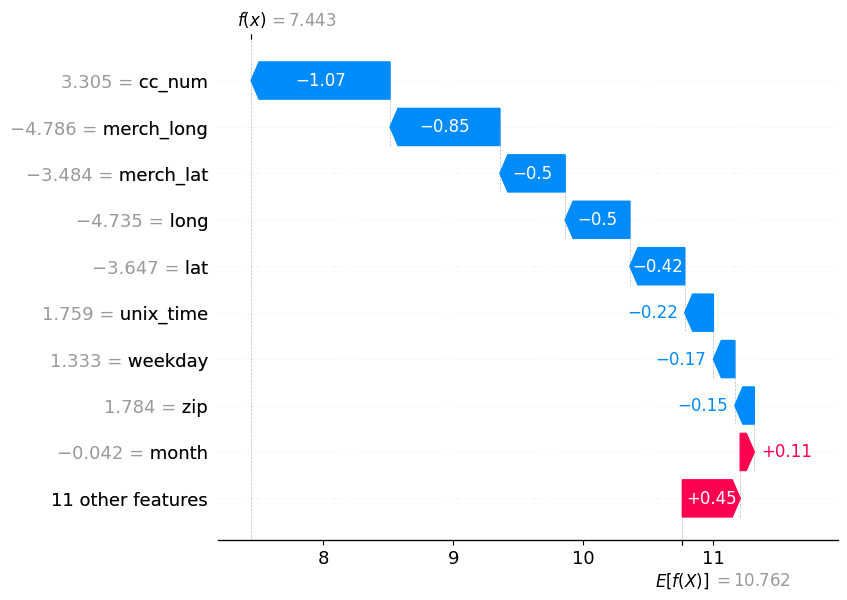


Explaining transaction index: 1245


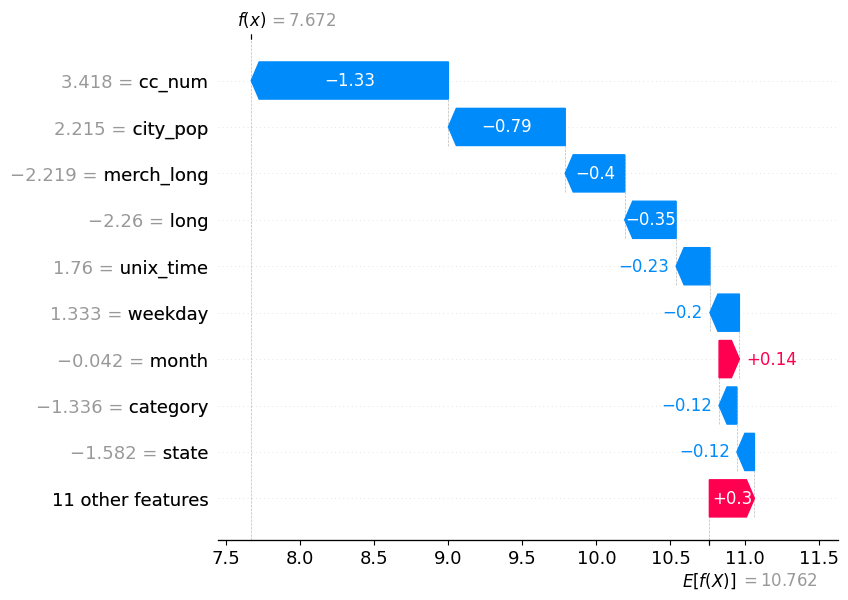


Explaining transaction index: 1426


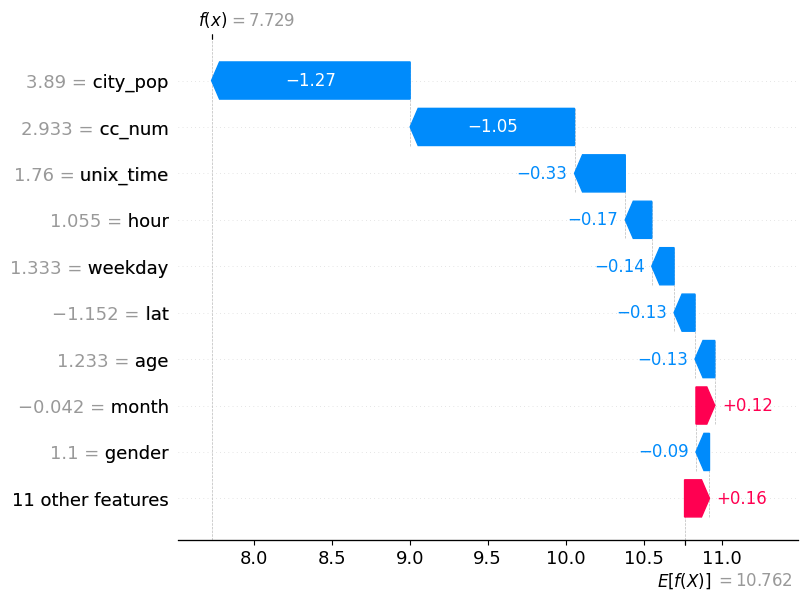


Explaining transaction index: 1494


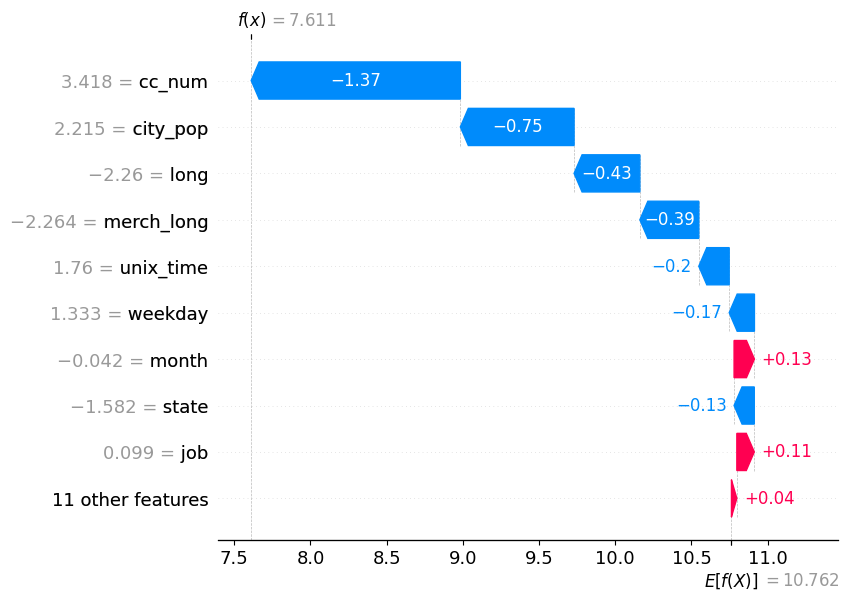


Explaining transaction index: 1553


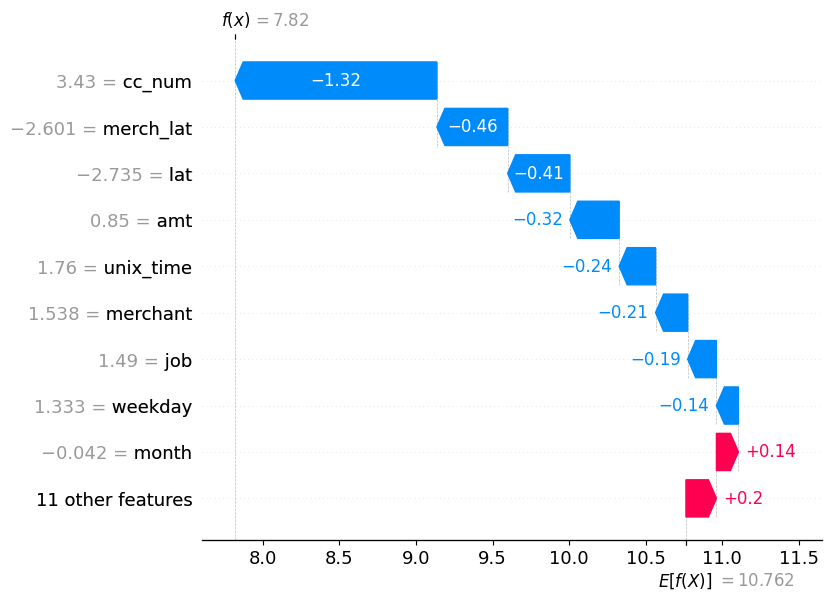

In [50]:
import shap

# Assume X_train and X_test are original DataFrames before scaling
feature_names = X_train.columns

# Reconstruct scaled DataFrames with original column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

# SHAP Explainer for Isolation Forest
explainer = shap.Explainer(iso_forest, X_train_scaled_df)
shap_values = explainer(X_test_scaled_df)

# Pick 5 fraud predictions
fraud_indices = np.where(test_preds_iso == 1)[0][:5]

# Explain those transactions using SHAP waterfall plots
for idx in fraud_indices:
    print(f"\nExplaining transaction index: {idx}")
    shap.plots.waterfall(shap_values[idx])

#### -----------------------------------------------------------------------------------------------------------------------------------------
## Interpretation of the first fraud detecton by the Isolation Forest model, using SHAP
#### -----------------------------------------------------------------------------------------------------------------------------------------

For the first fraud detection using Isolation Forest i.e. index 864:

- The prediction value dropped from 10.762 to 7.443 due to several strong negative SHAP contributions, indicating anomaly.

- Major contributors toward fraud flagging (blue bars):

cc_num = 3.305: SHAP value of −1.07

merch_long = −4.786: SHAP value of −0.85

merch_lat = −3.484: SHAP value of −0.5

long = −4.735 and lat = −3.647: Together contributed another ~−0.92

- These suggest that this transaction occurred at unusual merchant geolocations, or that the credit card number pattern was unusual based on what the model saw in normal data.

- What made it look normal (pink bars)?
month = −0.042 and zip = 1.784 had positive SHAP values of +0.45 and +0.11.
It means these made the transaction look a bit more normal or less fraudulent, but their influence was small compared to the negative contributors.

## False Positives and False Negatives Analysis

In [51]:
# Combine predictions and true labels
results = pd.DataFrame({
    'true': y_test_true,
    'pred_iso': test_preds_iso,
    'pred_lof': test_preds_lof
})

# False Positives and False Negatives for IF
false_positives_iso = results[(results['true'] == 0) & (results['pred_iso'] == 1)]
false_negatives_iso = results[(results['true'] == 1) & (results['pred_iso'] == 0)]

# False Positives and False Negatives for LOF
false_positives_lof = results[(results['true'] == 0) & (results['pred_lof'] == 1)]
false_negatives_lof = results[(results['true'] == 1) & (results['pred_lof'] == 0)]

print(f"\nFalse Positives (Isolation Forest): {len(false_positives_iso)}")
print(f"False Negatives (Isolation Forest): {len(false_negatives_iso)}")
print(f"\nFalse Positives (LOF): {len(false_positives_lof)}")
print(f"False Negatives (LOF): {len(false_negatives_lof)}")


False Positives (Isolation Forest): 3694
False Negatives (Isolation Forest): 2033

False Positives (LOF): 316768
False Negatives (LOF): 1099


## Summary

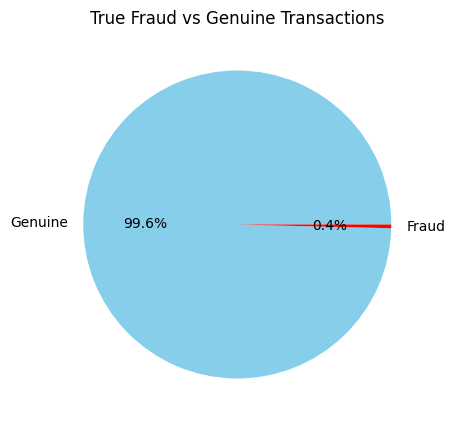

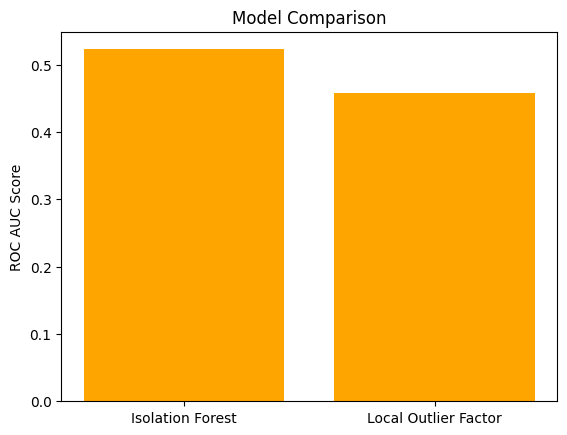

In [18]:
# Pie chart of fraud distribution
labels = ['Genuine', 'Fraud']
sizes = [sum(y_test_true==0), sum(y_test_true==1)]
colors = ['skyblue', 'red']

plt.figure(figsize=(5,5))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title("True Fraud vs Genuine Transactions")
plt.show()

# Bar chart for model comparison
models = ['Isolation Forest', 'Local Outlier Factor']
scores = [
    roc_auc_score(y_test_true, test_preds_iso),
    roc_auc_score(y_test_true, test_preds_lof)
]

plt.bar(models, scores, color='orange')
plt.ylabel("ROC AUC Score")
plt.title("Model Comparison")
plt.show()

## **Auto-encoder Model**

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [20]:
# train_df = pd.read_csv("fraudTrain.csv")
# test_df = pd.read_csv("fraudTest.csv")

# def preprocess(df):
#     df = df.copy()

#     df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
#     df['dob'] = pd.to_datetime(df['dob'])

#     df['age'] = (df['trans_date_trans_time'] - df['dob']).dt.days // 365
#     df['hour'] = df['trans_date_trans_time'].dt.hour
#     df['day'] = df['trans_date_trans_time'].dt.day
#     df['month'] = df['trans_date_trans_time'].dt.month
#     df['weekday'] = df['trans_date_trans_time'].dt.weekday

#     df.drop(columns=['trans_num', 'first', 'last', 'street', 'dob', 'trans_date_trans_time'], inplace=True)

#     cat_cols = df.select_dtypes(include='object').columns
#     for col in cat_cols:
#         df[col] = LabelEncoder().fit_transform(df[col].astype(str))

#     return df

# train_clean = preprocess(train_df)
# test_clean = preprocess(test_df)

# y_train_true = train_clean['is_fraud']
# y_test_true = test_clean['is_fraud']

# X_train = train_clean.drop(columns=['is_fraud'])
# X_test = test_clean.drop(columns=['is_fraud'])

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [21]:
input_dim = X_train_scaled.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation="relu")(input_layer)
encoded = Dense(16, activation="relu")(encoded)
encoded = Dense(8, activation="relu")(encoded)

decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │             672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,684 (10.48 KB)

 Trainable params: 2,684 (10.48 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Filter only non-fraud data
X_train_no_fraud = X_train_scaled[y_train_true == 0]

history = autoencoder.fit(
    X_train_no_fraud, X_train_no_fraud,
    epochs=20,
    batch_size=256,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)

Epoch 1/20
4533/4533 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.4712 - val_loss: 0.4033
Epoch 2/20
4533/4533 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.2998 - val_loss: 0.3889
Epoch 3/20
4533/4533 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.2820 - val_loss: 0.3746
Epoch 4/20
4533/4533 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.2721 - val_loss: 0.3581
Epoch 5/20
4533/4533 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.2620 - val_loss: 0.3516
Epoch 6/20
4533/4533 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.2576 - val_loss: 0.3701
Epoch 7/20
4533/4533 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.2549 - val_loss: 0.3679
Epoch 8/20
4533/4533 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.2529 - val_loss: 0.3596
Epoch 9/20
4533/4533 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.2513 - val_loss: 0.3685
Epoch 10/20
4533/4533 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.2502 - val_loss: 0.3625
Epoch 11/20
4533/4533 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.2491 - val_loss: 0.3490
Epoch 12/20
4533/4533 ━━━━━━━━

In [23]:
# Predict reconstruction
reconstructions = autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(X_test_scaled - reconstructions, 2), axis=1)

17367/17367 ━━━━━━━━━━━━━━━━━━━━ 16s 931us/step


In [24]:
threshold = np.percentile(mse, 95)  # Top 5% as anomalies

y_pred_ae = (mse > threshold).astype(int)

In [25]:
print("Confusion Matrix:\n", confusion_matrix(y_test_true, y_pred_ae))
print("Classification Report:\n", classification_report(y_test_true, y_pred_ae))
print("ROC AUC Score:", roc_auc_score(y_test_true, y_pred_ae))

Confusion Matrix:
 [[526217  27357]
 [  1716    429]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97    553574
           1       0.02      0.20      0.03      2145

    accuracy                           0.95    555719
   macro avg       0.51      0.58      0.50    555719
weighted avg       0.99      0.95      0.97    555719

ROC AUC Score: 0.5752905663922078


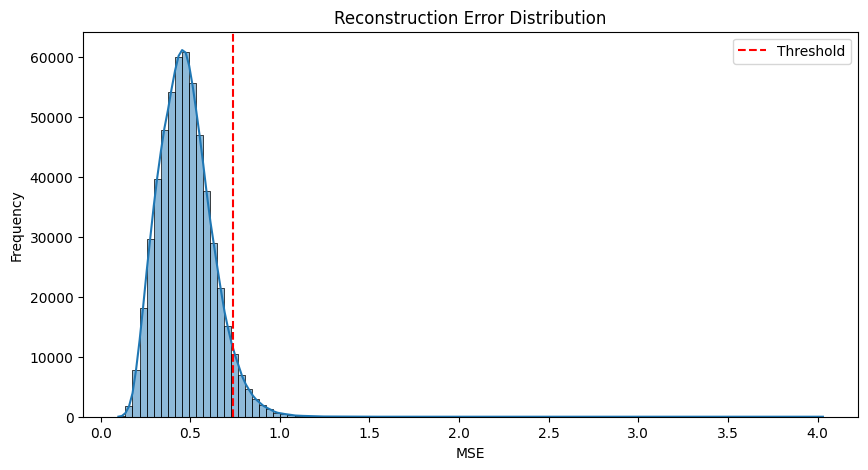

In [26]:
plt.figure(figsize=(10,5))
sns.histplot(mse, bins=100, kde=True)
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title("Reconstruction Error Distribution")
plt.xlabel("MSE")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Reason for flagging:

- Autoencoders learn to reproduce normal data.
- If reconstruction error is very high, the sample likely deviates from the learned pattern ⇒ potential fraud.

In [52]:
# Combine predictions and true labels
# Add Autoencoder predictions to results DataFrame
results['pred_ae'] = y_pred_ae

# False Positives and False Negatives for IF
false_positives_iso = results[(results['true'] == 0) & (results['pred_iso'] == 1)]
false_negatives_iso = results[(results['true'] == 1) & (results['pred_iso'] == 0)]
print(f"\nFalse Positives (Isolation Forest): {len(false_positives_iso)}")
print(f"False Negatives (Isolation Forest): {len(false_negatives_iso)}")

# False Positives and False Negatives for LOF
false_positives_lof = results[(results['true'] == 0) & (results['pred_lof'] == 1)]
false_negatives_lof = results[(results['true'] == 1) & (results['pred_lof'] == 0)]
print(f"\nFalse Positives (LOF): {len(false_positives_lof)}")
print(f"False Negatives (LOF): {len(false_negatives_lof)}")

# False Positives and False Negatives for Autoencoder
false_positives_ae = results[(results['true'] == 0) & (results['pred_ae'] == 1)]
false_negatives_ae = results[(results['true'] == 1) & (results['pred_ae'] == 0)]
print(f"\nFalse Positives (Autoencoder): {len(false_positives_ae)}")
print(f"False Negatives (Autoencoder): {len(false_negatives_ae)}")


False Positives (Isolation Forest): 3694
False Negatives (Isolation Forest): 2033

False Positives (LOF): 316768
False Negatives (LOF): 1099

False Positives (Autoencoder): 27357
False Negatives (Autoencoder): 1716


In [56]:
# Compute FP and FN for all three models
fp_iso = len(results[(results['true'] == 0) & (results['pred_iso'] == 1)])
fn_iso = len(results[(results['true'] == 1) & (results['pred_iso'] == 0)])

fp_lof = len(results[(results['true'] == 0) & (results['pred_lof'] == 1)])
fn_lof = len(results[(results['true'] == 1) & (results['pred_lof'] == 0)])

fp_ae = len(results[(results['true'] == 0) & (results['pred_ae'] == 1)])
fn_ae = len(results[(results['true'] == 1) & (results['pred_ae'] == 0)])

# Create DataFrame
fp_fn_df = pd.DataFrame({
    'Model': ['Isolation Forest', 'Local Outlier Factor', 'Autoencoder'],
    'False Positives': [fp_iso, fp_lof, fp_ae],
    'False Negatives': [fn_iso, fn_lof, fn_ae]
})

fp_fn_df.set_index('Model', inplace=True)

# Display the table
# print(fp_fn_df)
fp_fn_df.T

Model,Isolation Forest,Local Outlier Factor,Autoencoder
False Positives,3694,316768,27357
False Negatives,2033,1099,1716


In [58]:
# Total test samples
total_samples = len(y_test_true)

# Create the DataFrame with count and percentage (out of total samples)
fp_fn_df = pd.DataFrame({
    'Model': ['Isolation Forest', 'Local Outlier Factor', 'Autoencoder'],
    'False Positives': [
        f"{fp_iso} ({fp_iso / total_samples * 100:.2f}%)",
        f"{fp_lof} ({fp_lof / total_samples * 100:.2f}%)",
        f"{fp_ae} ({fp_ae / total_samples * 100:.2f}%)"
    ],
    'False Negatives': [
        f"{fn_iso} ({fn_iso / total_samples * 100:.2f}%)",
        f"{fn_lof} ({fn_lof / total_samples * 100:.2f}%)",
        f"{fn_ae} ({fn_ae / total_samples * 100:.2f}%)"
    ]
})

# Set 'Model' as index
fp_fn_df.set_index('Model', inplace=True)

# Display the result
# print(fp_fn_df)

fp_fn_df.T

Model,Isolation Forest,Local Outlier Factor,Autoencoder
False Positives,3694 (0.66%),316768 (57.00%),27357 (4.92%)
False Negatives,2033 (0.37%),1099 (0.20%),1716 (0.31%)


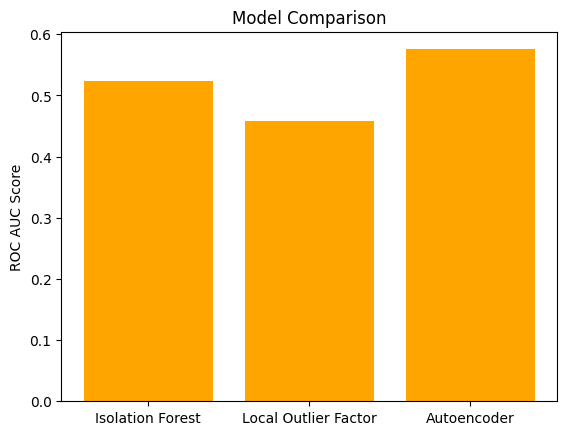

In [27]:
# Bar chart for model comparison
models = ['Isolation Forest', 'Local Outlier Factor', 'Autoencoder']
scores = [
    roc_auc_score(y_test_true, test_preds_iso),
    roc_auc_score(y_test_true, test_preds_lof),
    roc_auc_score(y_test_true, y_pred_ae)
]

plt.bar(models, scores, color='orange')
plt.ylabel("ROC AUC Score")
plt.title("Model Comparison")
plt.show()

## ROC Curve Plot

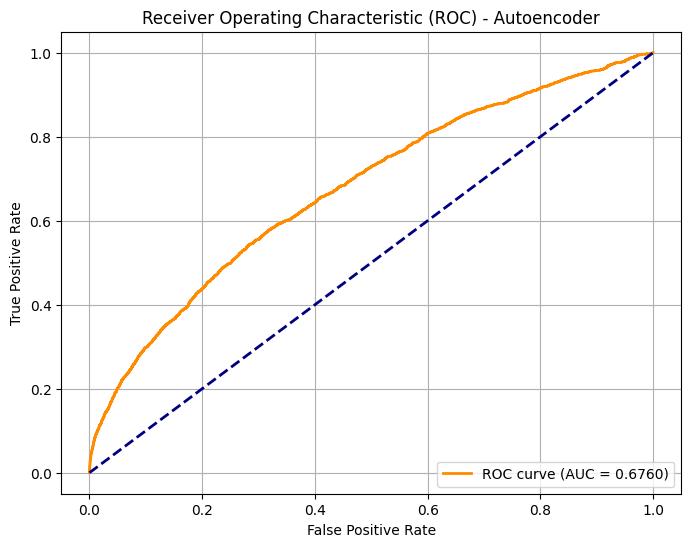

In [28]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test_true, mse)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Autoencoder')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## SHAP Explanations via Surrogate Model

 99%|===================| 1105159/1111438 [00:32<00:00]        

<Figure size 640x480 with 0 Axes>

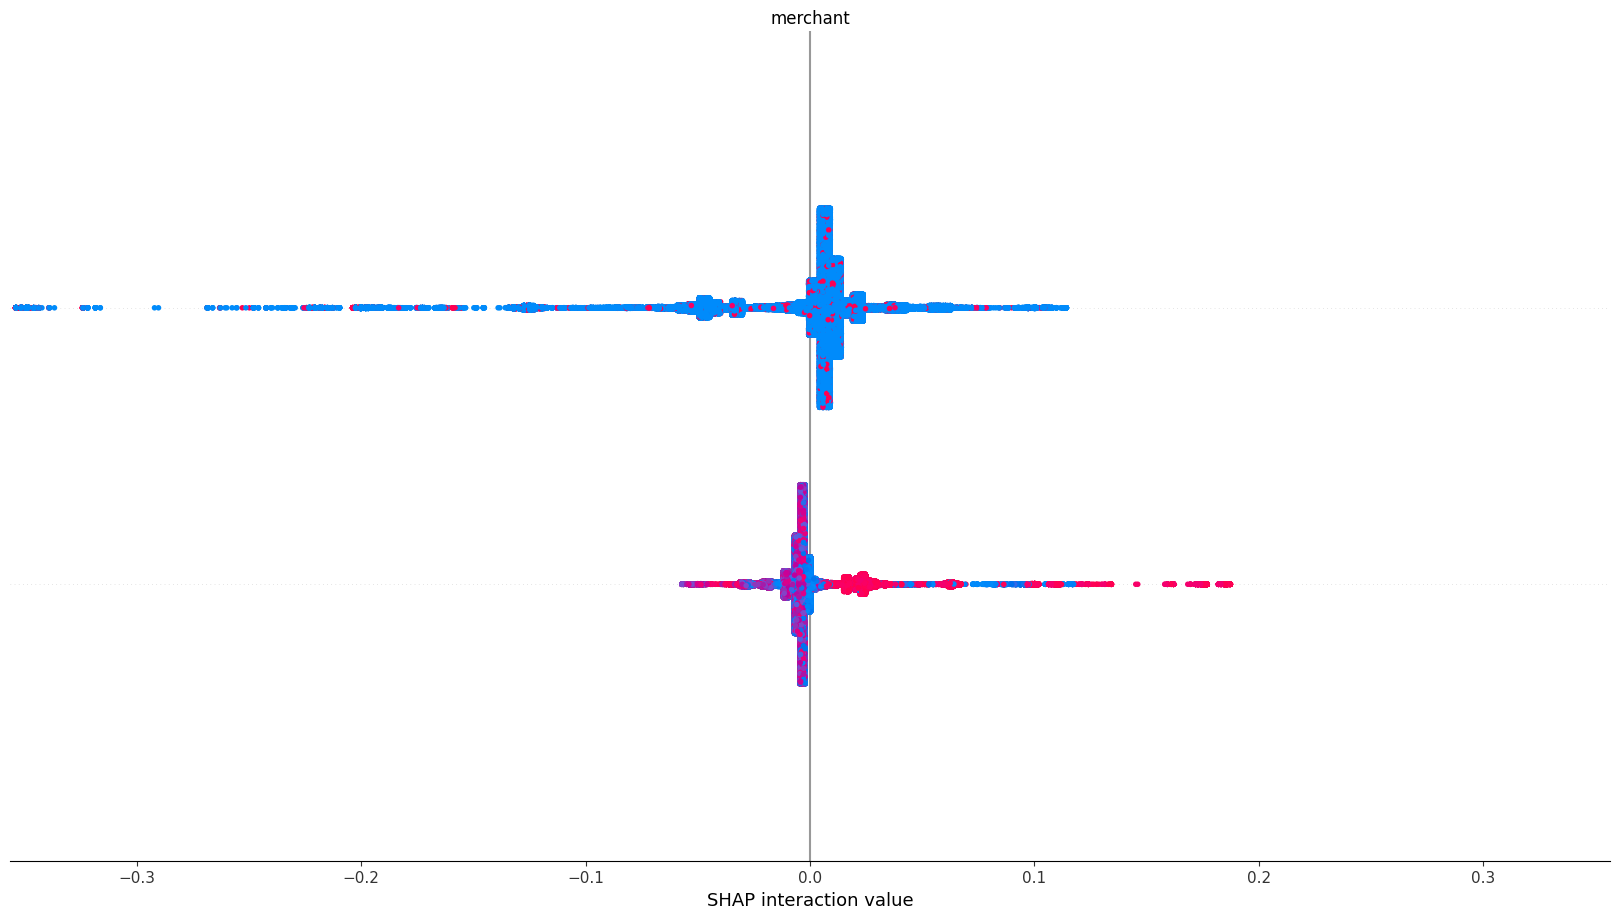

In [29]:
import shap
from sklearn.tree import DecisionTreeClassifier

# Train surrogate model using reconstruction error
surrogate = DecisionTreeClassifier(max_depth=5)
surrogate.fit(X_test_scaled, (mse > threshold).astype(int))

# SHAP explanation
explainer = shap.Explainer(surrogate, X_test_scaled)
shap_values = explainer(X_test_scaled) #[:100])  # Limit to 100 samples for performance

shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns, max_display=10)

In [59]:
new_df = test_df.copy()
new_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [60]:
new_df['IF_pred'] = test_preds_iso
new_df['LOF_pred'] = test_preds_lof
new_df['AE_pred'] = y_pred_ae

new_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,IF_pred,LOF_pred,AE_pred
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,0,0,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0,0,0,0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0,0,0,0
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0,0,0,0
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0,0,0,0


In [62]:
new_df.to_csv(r"D:\ML_Projects\ScienapticAI\fraudTest_Pred.csv")

## Conclusion

- Autoencoder model performed the best showing the highest ROC-AUC value


## Future Enhancements

- Hyper-parameter tuning can be performed to enhance the model accuracy.
- Ensemble model (of the three models used here) can be tried out.